In [394]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import json
import calendar

# Import API key
from config import gkey


In [395]:
# read CSV file 
file_to_load = "clean_sharks.csv"
shark_attacks = pd.read_csv(file_to_load)
shark_attacks.head()

,Attack Date,Year,Type,Country,Area,Location,Activity,Sex,Age,Injury,Fatal (Y/N),Species
0,2018-06-25,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,F,57,"No injury to occupant, outrigger canoe and pad...",N,White shark
1,2018-06-18,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,F,11,Minor injury to left thigh,N,NaN
2,2018-06-09,2018.0,Unknown,USA,Hawaii,"Habush, Oahu",Surfing,M,48,Injury to left lower leg from surfboard skeg,N,NaN
3,2018-06-08,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,M,NaN,Minor injury to lower leg,N,2 m shark
4,2018-06-04,2018.0,Provoked,MEXICO,Colima,La Ticla,Diving,M,NaN,Lacerations to leg & hand shark PROVOKED INCIDENT,N,"Tiger shark, 3m"


In [396]:
# Clean up some states with bad spacing
shark_attacks.loc[shark_attacks['Area'].str.contains('South Caro', na =False,case=False), 'Area'] = 'South Carolina'
shark_attacks.loc[shark_attacks['Area'].str.contains('North Caro', na =False,case=False), 'Area'] = 'North Carolina'

Text(0.5, 1.0, 'Shark Attacks by Country')

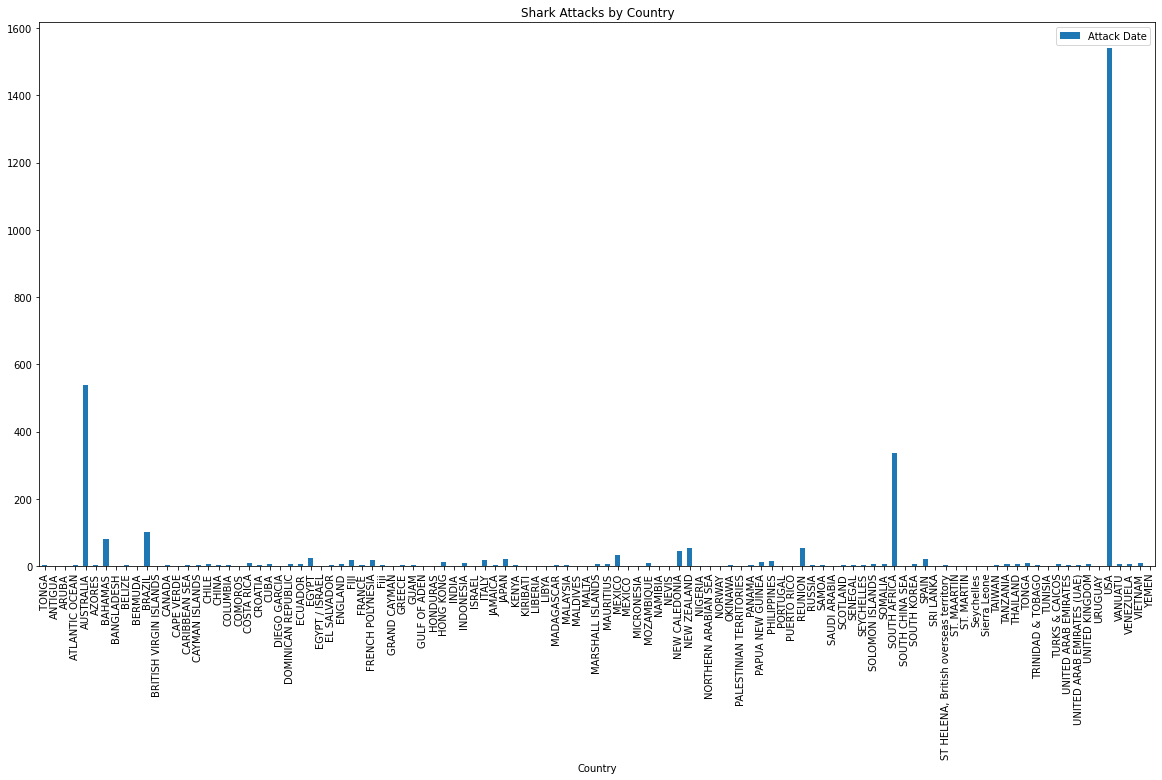

In [397]:
world_view_df = shark_attacks.groupby("Country")
country_list = pd.DataFrame(world_view_df.count()["Attack Date"])
country_list.sort_values("Attack Date",ascending= False)
country_list.plot(kind="bar", figsize=(20,10))
plt.title("Shark Attacks by Country")

In [398]:
# Looking for bad locations
shark_attacks.loc[shark_attacks['Location'].str.contains('Shell Island', na =False,case=False), 'Location'] = "Panama City Beach"


In [399]:
#get rid of some data that got booted originally in the google API
shark_attacks=shark_attacks.replace(
    {"Two miles off Key Colony Beach":"Key Colony Beach",
"Chatham Island":"Monomoy Island",
"2 miles off Pompano Beach":"Pompano Beach",
"24 km off Santa Catalina Island in the Channel Islands":"Santa Catalina Island",
"3 miles off Jupiter":"Jupiter",
"3 to 4 miles west of Indian Pass":"Indian Pass",
"6 miles south of Boca  Chica Key":"Boca Chica Key",
"8 miles off Mobile":"Mobile",
"20 miles from Mayport":"Mayport",
"2 miles off Keahole Airport":"Keahole Airport",
"16 miles off Hilton Head":"Hilton Head",
"10 miles off Cape Canaveral":"Cape Canaveral",
"100 miles off Ft. Myers Beach":"Ft. Myers Beach",
"100 miles off Ocean City":"Ocean City",
"11 miles off Dog Island in the Gulf of Mexico":"Dog Island",
"12 miles northeast of Mayport":"Mayport",
"150 miles from Crystal River":"Crystal River",
"Malaka":"Makaha",
"In Gulf of Mexico 17 miles off Weeki Wachee ":"Weeki Wachee",
})

In [400]:
bins = [0, 1981, 1986, 1991, 1996, 2001, 2006, 2011, 2016, 2021]
group_names = ["1975-1980", "1980-1985", "1985-1990", "1990-1995", "1995-2000","2000-2005","2005-2010","2010-2015","2015-2020"]
    
shark_attacks["Period"] = pd.cut(shark_attacks["Year"], bins, labels=group_names, include_lowest=False)
shark_attacks

,Attack Date,Year,Type,Country,Area,Location,Activity,Sex,Age,Injury,Fatal (Y/N),Species,Period
0,2018-06-25,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,F,57,"No injury to occupant, outrigger canoe and pad...",N,White shark,2015-2020
1,2018-06-18,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,F,11,Minor injury to left thigh,N,NaN,2015-2020
2,2018-06-09,2018.0,Unknown,USA,Hawaii,"Habush, Oahu",Surfing,M,48,Injury to left lower leg from surfboard skeg,N,NaN,2015-2020
3,2018-06-08,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,M,NaN,Minor injury to lower leg,N,2 m shark,2015-2020
4,2018-06-04,2018.0,Provoked,MEXICO,Colima,La Ticla,Diving,M,NaN,Lacerations to leg & hand shark PROVOKED INCIDENT,N,"Tiger shark, 3m",2015-2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,1975-02-10,1975.0,Unprovoked,AUSTRALIA,South Australia,(Point Sinclair) Penong,Swimming,M,12,Right leg severed FATAL,Y,"White shark, 3 m [10']",1975-1980
3188,1975-02-09,1975.0,Unprovoked,AUSTRALIA,Victoria,Anglesea,Fishing,M,45,Puncture wounds to right shoulder,N,"Carpet shark, 10'",1975-1980
3189,1975-02-07,1975.0,Unprovoked,AUSTRALIA,Queensland,Currumbin Rock,NaN,M,NaN,Survived,N,NaN,1975-1980
3190,1975-02-01,1975.0,Provoked,SOUTH AFRICA,Western Cape Province,"Beespens, False Bay",Fishing,M,12,Foot bitten by shark he was gaffing PROVOKED ...,N,"Copper shark, 50-kg [110-b]",1975-1980


In [401]:
# Work to isolate the month from the attack date, grabbing a string from character 5-7 and storing as Integer to use the Calendor import
shark_attacks['Mth']=shark_attacks["Attack Date"].str[5:7].astype(int)

#sorting to get the values 1-12
shark_attacks_sorted = shark_attacks.sort_values(["Mth"])

#using the calendar import to attach the month name abbrevation
shark_attacks_sorted['Mth Name'] = shark_attacks['Mth'].apply(lambda x: calendar.month_abbr[x])

#Concatenating for graphing axis, liked it bettter than just the standard month number of month abbrev
shark_attacks_sorted["Month of the Year"] = shark_attacks_sorted['Mth'].astype(str)+"-"+shark_attacks_sorted['Mth Name']


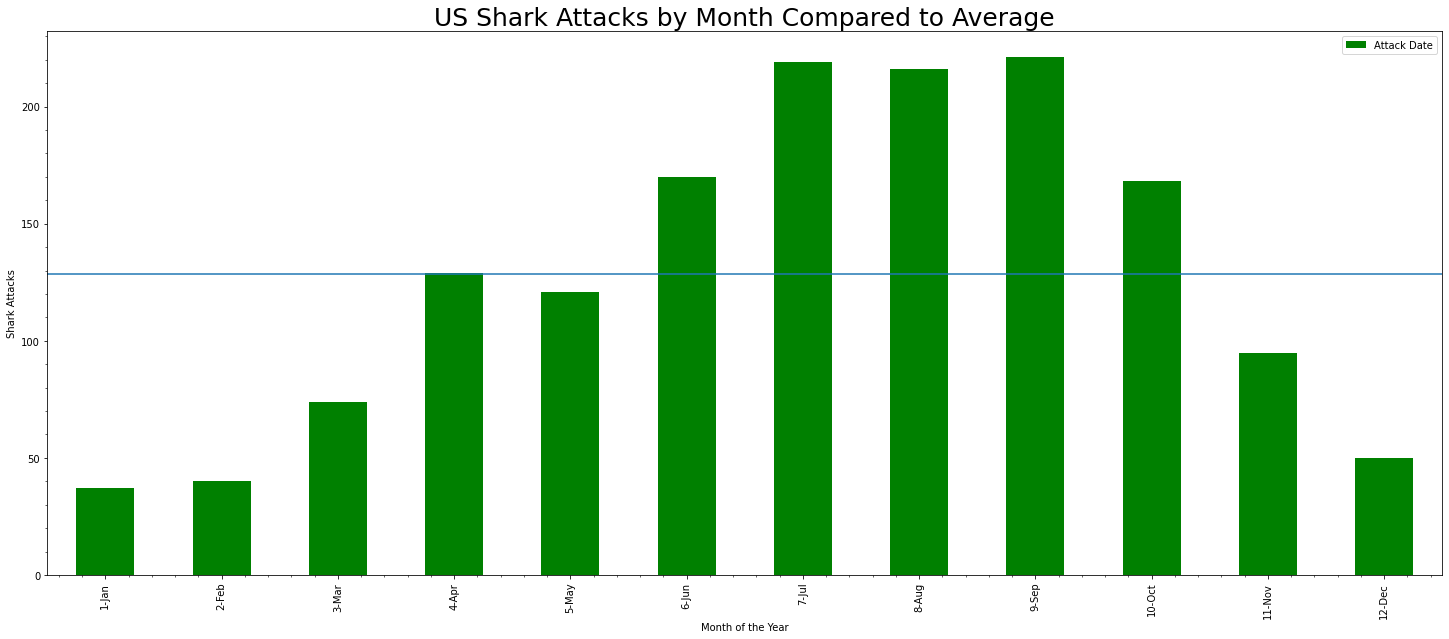

In [402]:
#separating out the US again, as the world is just too difficult at this juncture
monthly_attacks = shark_attacks_sorted[shark_attacks_sorted["Country"]=="USA"].groupby(["Month of the Year","Mth"]).count()["Attack Date"]
monthly_attacks_df = pd.DataFrame(monthly_attacks)
monthly_sort = monthly_attacks_df.reset_index()

#sort by month, remake the dataframe with just the two data points for graphing purposes
month_plt_srt = monthly_sort.sort_values('Mth')
month_plt = month_plt_srt[["Month of the Year","Attack Date"]]

# plot setup
fig,ax= plt.subplots()

month_plt.set_index('Month of the Year').plot(kind="bar", ax=ax, color='g',figsize=(25,10))

plt.minorticks_on()
ax.tick_params(axis='x',which='minor',bottom='off')
ax.set_xlabel("Month of the Year")
ax.set_ylabel("Shark Attacks")
ax.set_title(("US Shark Attacks by Month Compared to Average"), fontsize=25)

# use axhline
mean = month_plt["Attack Date"].mean()
ax.axhline(mean)

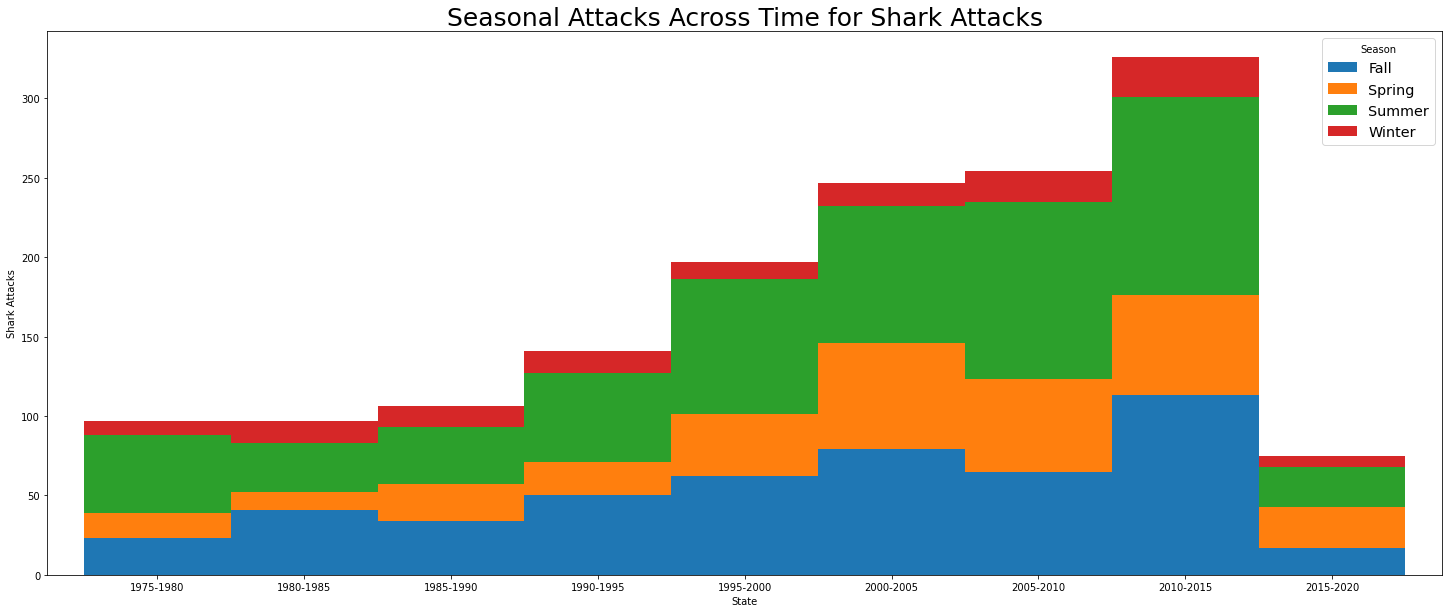

In [413]:
#Adding the season column in
shark_attack_season_us.loc[:,"Season"] = " "

#iterating through each row to get the seasonal name (Meteorilogical not Astrological seasons)
for index,row in shark_attack_season_us.iterrows():
    
    if row.loc["Mth"] == 12:
        shark_attack_season_us.loc[index,"Season"] = "Winter"
    
    elif (row.loc["Mth"] < 12) & (row.loc["Mth"] >= 9):
        shark_attack_season_us.loc[index,"Season"] = "Fall"

    elif (row.loc["Mth"] < 9) & (row.loc["Mth"] >= 6):
        shark_attack_season_us.loc[index,"Season"] = "Summer"

    elif (row.loc["Mth"] < 6) & (row.loc["Mth"] >= 3):
        shark_attack_season_us.loc[index,"Season"] = "Spring"

    else:
        shark_attack_season_us.loc[index,"Season"] = "Winter"
    
#set the group by for my charting
season_plt = shark_attack_season_us.groupby(["Period","Season"]).size()

#the chart looked bad for all states, cutting down on the returned data
season_sort_plt = season_plt.groupby(["Period","Season"]).sum().sort_values(ascending=False)

#actually plot it
season_sort_plt.unstack().plot(kind='bar',stacked=True,figsize =(25,10), width=1)

#add the goodies
plt.title("Seasonal Attacks Across Time for Shark Attacks", fontsize = 25)
plt.legend(loc="best", ncol = 1, fontsize="x-large",title="Season")
plt.ylabel("Shark Attacks")
plt.xlabel("State")
plt.xticks(rotation=0)
plt.show()

In [220]:
US_attacks = shark_attacks[shark_attacks["Country"]=="USA"]
# pd.set_option('max_rows', None)
US_state_Attacks = US_attacks.groupby(["Area","Period"]).count()["Attack Date"]
state_attacks_df = pd.DataFrame(US_state_Attacks)
state_attacks_df

Attack Date
Area       Period                
Alabama    1975-1980            1
           1980-1985            1
           1985-1990            0
           1990-1995            0
           1995-2000            2
...                           ...
Washington 1995-2000            0
           2000-2005            0
           2005-2010            0
           2010-2015            0
           2015-2020            1

[261 rows x 1 columns]

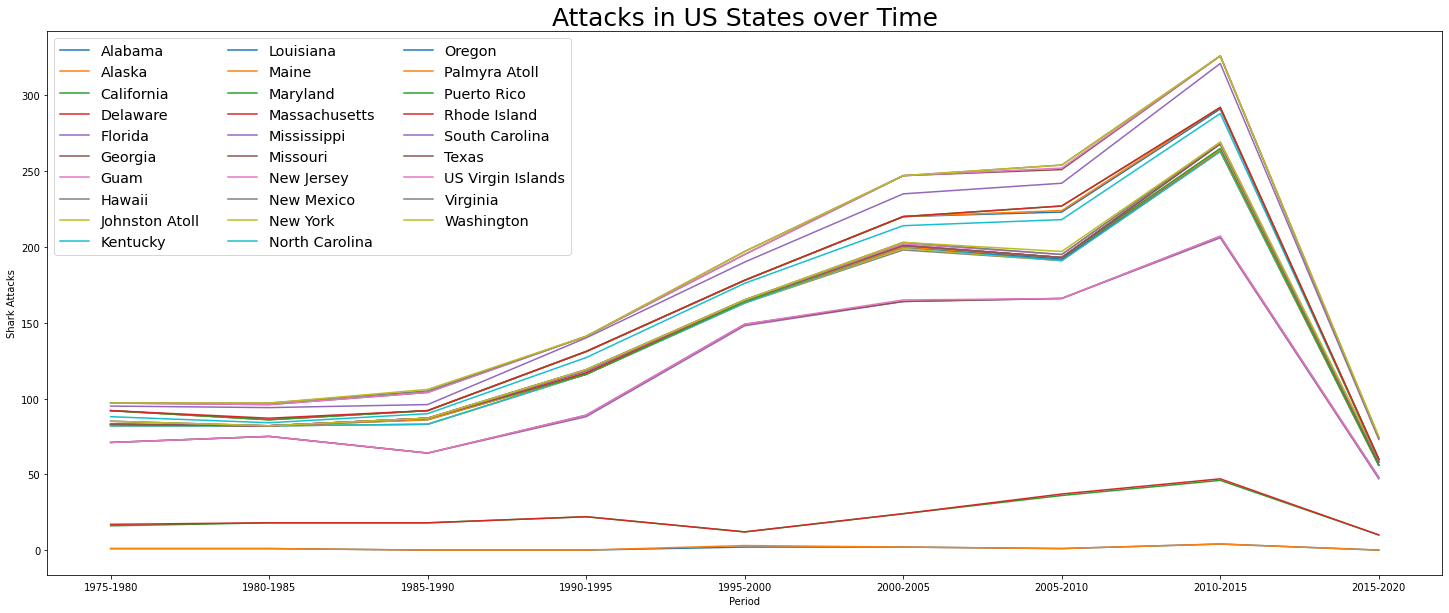

In [358]:
US_attacks.groupby(["Period","Area"]).size().unstack().plot(kind='line', stacked=True, figsize=(25, 10))
plt.title("Attacks in US States over Time",fontsize=25)
plt.legend(loc="best", ncol = 3, fontsize="x-large")
plt.ylabel("Shark Attacks")
plt.show()

In [222]:
us_attacks_simple = US_attacks[["Year","Area","Location","Period"]]

us_attacks_simple

,Year,Area,Location,Period
0,2018.0,California,"Oceanside, San Diego County",2015-2020
1,2018.0,Georgia,"St. Simon Island, Glynn County",2015-2020
2,2018.0,Hawaii,"Habush, Oahu",2015-2020
7,2018.0,Florida,"Lighhouse Point Park, Ponce Inlet, Volusia County",2015-2020
8,2018.0,Florida,"Cocoa Beach, Brevard County",2015-2020
...,...,...,...,...
3172,1975.0,Florida,"Daytona Beach, Volusia County",1975-1980
3173,1975.0,Florida,"New Smyrna Beach, Volusia County",1975-1980
3174,1975.0,Florida,"New Smyrna Beach, Volusia County",1975-1980
3175,1975.0,Florida,"Daytona Beach, Volusia County",1975-1980


In [223]:
us_attacks_simple.loc[:,"New Location"] = us_attacks_simple.loc[:,'Location'].str.split(',', 1).str[0]
us_attacks_simple.copy()
us_attacks_simple.loc[:,("City Lookup")] = us_attacks_simple.loc[:,'New Location']+", "+us_attacks_simple.loc[:,'Area']
us_attacks_simple.copy()

C:\Users\andre\anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\andre\anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Year,Area,Location,Period,New Location,City Lookup
0,2018.0,California,"Oceanside, San Diego County",2015-2020,Oceanside,"Oceanside, California"
1,2018.0,Georgia,"St. Simon Island, Glynn County",2015-2020,St. Simon Island,"St. Simon Island, Georgia"
2,2018.0,Hawaii,"Habush, Oahu",2015-2020,Habush,"Habush, Hawaii"
7,2018.0,Florida,"Lighhouse Point Park, Ponce Inlet, Volusia County",2015-2020,Lighhouse Point Park,"Lighhouse Point Park, Florida"
8,2018.0,Florida,"Cocoa Beach, Brevard County",2015-2020,Cocoa Beach,"Cocoa Beach, Florida"
...,...,...,...,...,...,...
3172,1975.0,Florida,"Daytona Beach, Volusia County",1975-1980,Daytona Beach,"Daytona Beach, Florida"
3173,1975.0,Florida,"New Smyrna Beach, Volusia County",1975-1980,New Smyrna Beach,"New Smyrna Beach, Florida"
3174,1975.0,Florida,"New Smyrna Beach, Volusia County",1975-1980,New Smyrna Beach,"New Smyrna Beach, Florida"
3175,1975.0,Florida,"Daytona Beach, Volusia County",1975-1980,Daytona Beach,"Daytona Beach, Florida"


In [373]:
list_of_possible_locations = us_attacks_simple[["City Lookup"]]
list_vc = list_of_possible_locations.value_counts().reset_index()

In [374]:
list_loc_df=pd.DataFrame(list_vc)
list_loc_df['Lat']=" "
list_loc_df['Lng']=" "

list_loc_df

,City Lookup,0,Lat,Lng
0,"New Smyrna Beach, Florida",166,,
1,"Ponce Inlet, Florida",33,,
2,"Daytona Beach, Florida",28,,
3,"Cocoa Beach, Florida",20,,
4,"Melbourne Beach, Florida",19,,
...,...,...,...,...
834,"Kahe Point, Hawaii",1,,
835,"Kahului, Hawaii",1,,
836,"Kailua Bay, Hawaii",1,,
837,"Kailua-Kona, Hawaii",1,,


In [375]:
# In case I make updates and want to run the API for just a small set of data
test = list_loc_df.head(10)
test

,City Lookup,0,Lat,Lng
0,"New Smyrna Beach, Florida",166,,
1,"Ponce Inlet, Florida",33,,
2,"Daytona Beach, Florida",28,,
3,"Cocoa Beach, Florida",20,,
4,"Melbourne Beach, Florida",19,,
5,"Myrtle Beach, South Carolina",18,,
6,"Isle of Palms, South Carolina",15,,
7,"Singer Island, Florida",12,,
8,"Ormond Beach, Florida",10,,
9,"Playalinda Beach, Florida",10,,


In [376]:
# Run a request to endpoint and convert result to json

lonely_city = []


for index,row in list_loc_df.iterrows():
    
    target_city_row = row["City Lookup"]
    
    target_city = f"{target_city_row}"

# Build the endpoint URL
    target_url = ('https://maps.googleapis.com/maps/api/geocode/json?'
    'address={0}&key={1}').format(target_city, gkey)
    
    geo_data = requests.get(target_url).json()
    
# Extract latitude and longitude
    try:
        list_loc_df.loc[index,"Lat"] = geo_data["results"][0]["geometry"]["location"]["lat"]
        list_loc_df.loc[index,"Lng"] = geo_data["results"][0]["geometry"]["location"]["lng"]
        print(f"Record found at {target_city}")
    except (KeyError, IndexError):
        print(f"Record could not be found at {target_city}")
        lonely_city = target_city_row

Record found at New Smyrna Beach, Florida
Record found at Ponce Inlet, Florida
Record found at Daytona Beach, Florida
Record found at Cocoa Beach, Florida
Record found at Melbourne Beach, Florida
Record found at Myrtle Beach, South Carolina
Record found at Isle of Palms, South Carolina
Record found at Singer Island, Florida
Record found at Ormond Beach, Florida
Record found at Playalinda Beach, Florida
Record found at Jacksonville Beach, Florida
Record found at Palm Beach, Florida
Record found at Florida Keys, Florida
Record found at Daytona Beach Shores, Florida
Record found at Jensen Beach, Florida
Record found at Vero Beach, Florida
Record found at Jacksonville, Florida
Record found at Bethune Beach, Florida
Record found at Mustang Island, Texas
Record found at Sanibel Island, Florida
Record found at Juno Beach, Florida
Record found at Fort Lauderdale, Florida
Record found at Gulf Shores, Alabama
Record found at South Padre Island, Texas
Record found at Riviera Beach, Florida
Record

Record found at Palm Beach Shores, Florida
Record found at Padre Island, Texas
Record found at Padre Island National Seashore, Texas
Record found at Pacific State , California
Record found at Palm Beach?, Florida
Record found at Ormond-by-the-Sea, Florida
Record found at Palmetto Dunes, South Carolina
Record found at Pamlico Sound, North Carolina
Record found at Pensacola  Beach, Florida
Record found at Pensacola Bay, Florida
Record found at Panama City, Florida
Record found at Oswald State Park, Oregon
Record found at Pajaro Dunes, California
Record found at  Cocoa Beach, Florida
Record found at Opposite Patrick Air Force Base, Florida
Record found at North Salmon Creek Beach, California
Record found at North Beach Jetty, Florida
Record found at North Carolina Aquarium at Fort Fisher, North Carolina
Record found at North Dade- Interama area of Biscayne Bay, Florida
Record found at North Forest Beach, South Carolina
Record found at North Hutchinson Island, Florida
Record found at North

Record found at South of Cocoa Beach, Florida
Record found at Pet Den, Florida
Record found at Salmon Beach, California
Record found at Quarter mile south of Ponce de Leon Inlet, Florida
Record found at Quebradillas, Puerto Rico
Record found at Refugio State Beach, California
Record found at Resident's Beach, Florida
Record found at Rockaway, New York
Record found at Rocky Point, Hawaii
Record found at Running Waters Beach, Hawaii
Record found at Near Cocoa Beach, Florida
Record found at Salmon Creek Beach, California
Record found at Punaluu, Hawaii
Record found at Salvo, North Carolina
Record found at Samoa Beach, California
Record found at San Diego County, California
Record found at San Nicholas Island, California
Record found at Sand Key Beach, Florida
Record found at Sandbridge Beach, Virginia
Record found at Sandridge Beach, Virginia
Record found at Sands Cut, Florida
Record found at Quarter mile offshore in Kaanapali, Hawaii
Record found at Public Beach, Florida
Record found at 

Record found at 90 miles east of Hilo, Hawaii
Record found at A quarter mile north of Fort Pierce Inlet, Florida
Record found at Abalone Point, California
Record found at Adventure Aquarium, New Jersey
Record found at Airplane Beach, Hawaii
Record found at Ala Moana Beach Park, Hawaii
Record found at Albuquerue Aquarium, New Mexico
Record found at Alenuihaha Channel, Hawaii
Record found at Alligator Reef off Islamorada, Florida
Record found at Alligator Reef, Florida
Record found at Amelia Island, Florida
Record could not be found at 3 to 4 miles west of Indian Pass, Florida
Record could not be found at 3 miles off Jupiter, Florida
Record found at Bob Graham Beach, Florida
Record found at 3 miles east of Jacksonville Beach, Florida
Record found at  Huntington Beach, California
Record found at  Kahului, Hawaii
Record found at  New Smyrna Beach, Florida
Record found at  Palm Beach County, Florida
Record found at  Riviera Beach, Florida
Record found at  Vieques, Puerto Rico
Record found a

Record found at Honomuni, Hawaii
Record found at Hooipa Beach Park, Hawaii
Record found at Horners, Hawaii
Record found at Horseshoe Reef, California
Record found at Horseshoe Rock, California
Record found at Howard E. Futch Memorial Park at Paradise Beach, Florida
Record found at Hugenot Beach , Florida
Record found at Huguenot Memorial Park, Florida
Record found at Huguenot Park, Florida
Record found at Hultin's Beach, Hawaii
Record found at Humboldt Bay, California
Record found at Haulover Beach, Florida
Record found at Hapuna Beach, Hawaii
Record found at Key Colony Beach, Florida
Record found at Hanalei Point, Hawaii
Record found at Gold  Beach, Oregon
Record found at Gold Beach, Oregon
Record found at Grand Strand, South Carolina
Record found at Grass Island, Texas
Record found at Gulf Island National Seashore Park, Florida
Record found at Gulf Islands National Seashore, Florida
Record found at Gulf Shores Beach, Alabama
Record found at Gulf of Mexico, Alabama
Record found at Gul

In [382]:
# "1975-1980", "1980-1985", "1985-1990", "1990-1995", "1995-2000","2000-2005","2005-2010","2010-2015","2015-2020"
list_loc_df

,City Lookup,0,Lat,Lng
0,"New Smyrna Beach, Florida",166,29.025819,-80.926998
1,"Ponce Inlet, Florida",33,29.096373,-80.936998
2,"Daytona Beach, Florida",28,29.210815,-81.022833
3,"Cocoa Beach, Florida",20,28.320007,-80.607551
4,"Melbourne Beach, Florida",19,28.06835,-80.56033
...,...,...,...,...
834,"Kahe Point, Hawaii",1,21.354167,-158.130556
835,"Kahului, Hawaii",1,20.889335,-156.472947
836,"Kailua Bay, Hawaii",1,19.63841,-155.995581
837,"Kailua-Kona, Hawaii",1,19.639994,-155.996926


In [383]:
output = "lat_long_results.csv"
list_loc_df.to_csv(output, encoding="utf-8", index=False)

In [384]:
list_loc_df.rename(columns={0: 'Reported Attacks'}, inplace = True)
list_loc_df

,City Lookup,Reported Attacks,Lat,Lng
0,"New Smyrna Beach, Florida",166,29.025819,-80.926998
1,"Ponce Inlet, Florida",33,29.096373,-80.936998
2,"Daytona Beach, Florida",28,29.210815,-81.022833
3,"Cocoa Beach, Florida",20,28.320007,-80.607551
4,"Melbourne Beach, Florida",19,28.06835,-80.56033
...,...,...,...,...
834,"Kahe Point, Hawaii",1,21.354167,-158.130556
835,"Kahului, Hawaii",1,20.889335,-156.472947
836,"Kailua Bay, Hawaii",1,19.63841,-155.995581
837,"Kailua-Kona, Hawaii",1,19.639994,-155.996926


In [385]:
coord_df = list_loc_df[list_loc_df["Lat"] != " "]
coord_df

coordinates = coord_df.loc[:,("Lat","Lng")].values.tolist()

In [386]:
# Access maps with unique API key
gmaps.configure(api_key=gkey)

In [387]:
# Customize the size of the figure
figure_layout = {
    'width': '800px',
    'height': '500px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout,zoom_level=3,center=(25,-80))

In [388]:
# Assign the marker layer to a variable
markers = gmaps.marker_layer(coordinates)
# Add the layer to the map
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='500px', margin='0 auto 0 auto', padding='1px', wi…

In [389]:
#setup of heatmap plotting criteria 
location_df = coord_df[["Lat", "Lng"]]
attacks_df = coord_df['Reported Attacks']

In [390]:
figure_layout = {
    'width': '800px',
    'height': '500px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(figure_layout,zoom_level=4,center=(35,-90))

heat_layer = gmaps.heatmap_layer(location_df, weights=attacks_df, 
                                 dissipating=False,point_radius=5, opacity =.5)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))